In [2]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity
using StatsBase
using DataFrames
using RCall
using SparseArrays

 Activating environment at `~/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling HypergraphModularity [0c934d27-dd44-49d7-950f-bd4be7819e54]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphModularity does not have DelimitedFiles in its dependencies:
│ - If you have HypergraphModularity checked out for development and have
│   added DelimitedFiles as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphModularity
└ Loading DelimitedFiles into HypergraphModularity from project dependency, future warnings for HypergraphModularity are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [15]:
# H, Z = read_hypergraph_data("walmart-trips", 20)
kmax = 20
H, Z = read_hypergraph_data("walmart-trips", kmax) # VERY good results on Trivago with 3-5 core
# H, Z = read_hypergraph_data("congress-bills", 20) 

Base.copy(H::hypergraph) = hypergraph(H.N, H.E, H.D)

In [17]:
[(k, length(H.E[k])) for k in keys(H.E)]

20-element Array{Tuple{Int64,Int64},1}:
 (18, 754)
 (2, 12838)
 (16, 1013)
 (11, 1860)
 (7, 3640)
 (9, 2574)
 (10, 2170)
 (19, 667)
 (17, 864)
 (8, 3081)
 (6, 4527)
 (4, 7651)
 (3, 10110)
 (5, 5792)
 (20, 659)
 (14, 1260)
 (13, 1517)
 (15, 1145)
 (12, 1688)
 (1, 0)

In [5]:
function projectedGraph(H)
    
    n = length(H.D)
    A = CliqueExpansion(H, false, false)
    ix, jx, w = findnz(A)
    E = Dict(sort([ix[k], jx[k]]) => w[k] for k in 1:length(ix))

    H̄ = hypergraph(collect(1:n), Dict(1 => Dict(), 2 => E), [0])
    HypergraphModularity.computeDegrees!(H̄);
    return H̄
end

projectedGraph (generic function with 1 method)

In [45]:
DF = DataFrame()

kmax = 20

for core ∈ [4, 6]
    
    H, Z = read_hypergraph_data("walmart-trips", kmax)
        # extract core
    println("Extracting $(core)-core")

    H_, Z_ = copy(H), copy(Z)

    for i in 1:10
        H_, Z_ = subHypergraph(H_, H_.D .>= core, Z_)
    end
    
    n = length(H_.D)
    
    println("$(core)-core has $n nodes")

    for k ∈ reverse(3:kmax)
        println("  kmax = $k")
        
        for kay in keys(H_.E)
            if kay > k
                pop!(H_.E, kay)
            end
        end
        
        HypergraphModularity.computeDegrees!(H_)
        H̄ = projectedGraph(H_)
        
        Ω̂ = estimateΩEmpirically(H_, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        println("    Polyadic experiments")
        print("    ")
        for i ∈ 1:20 
            print("$i ")
            Ẑ, t = @timed SuperNode_PPLouvain(H_, Ω̂; α = 0, verbose = false, Z0 = collect(1:n))
            Ω̂ = estimateΩEmpirically(H_, Ẑ; aggregator = p -> [length(p) == 1, sum(p)], bigNums = true);
            Q = modularity(H_, Ẑ, Ω̂; α = nothing) - n*log(length(unique(Z)))
            ℓ = length(unique(Ẑ))
            NMI = mutualInformation(Z_, Ẑ, true)
            df = DataFrame(kmax = k, ℓ = ℓ, Q = Q, t = t, NMI = NMI, method = "Polyadic", n = n, core = core)
            DF = vcat(DF, df)
        end
        println("")

        println("    Dyadic experiments")
        print("    ")

        Ω̄ = estimateΩEmpirically(H̄, Z_; aggregator = p -> [length(p) == 1, sum(p)])
        for i ∈ 1:20
            print("$i ")
            Ẑ, t = @timed SuperNode_PPLouvain(H̄, Ω̄; α = 0, verbose = false)
            Ω̄ = estimateΩEmpirically(H̄, Ẑ; aggregator = p -> [length(p) == 1, sum(p)])
            Q = modularity(H̄, Ẑ, Ω̄; α = 0)
            ℓ = length(unique(Ẑ))
            NMI = mutualInformation(Z_, Ẑ, true)
            df = DataFrame(kmax = k, ℓ = ℓ, Q = Q, method = "Dyadic", t = t, NMI = NMI, n = n, core = core)
            DF = vcat(DF, df)
        end
        println("")
    end
end

Extracting 4-core
4-core has 534 nodes
  kmax = 20
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 19
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 18
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 17
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 16
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
  kmax = 15
    Polyadic experiments
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
    Dyad

In [46]:
R"""
library(tidyverse)
""";

In [73]:
R"""
df <- tibble($DF)

df %>% write_csv("fig/walmart_throughput.csv")
""";

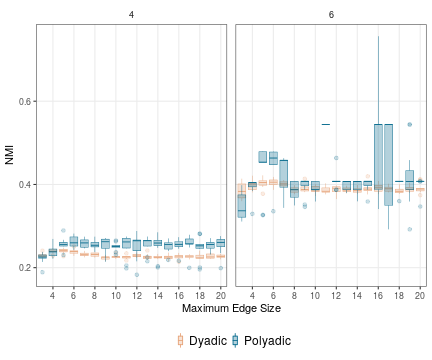

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [74]:
R"""

# levels <- c("2-Core (13,960 nodes)", "5-Core (335 nodes)", "10-Core (23 nodes)")

df %>% 
    arrange(desc(core)) %>% 
    group_by(method, kmax, core) %>% 
    filter(row_number() >= 10) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) %>% 
  #  mutate(core = paste0(core, "-Core (", n_, " nodes)"),
  #         core = factor(core, levels = levels),
  #         method = factor(method)) %>% 
    ggplot() + 
    aes(x = factor(kmax), y = NMI) + 
    geom_boxplot(aes(color = method, fill = method), lwd = 0.2, outlier.alpha = .2, position = position_identity(), alpha = 0.3) + 
    facet_grid(~core) + 
    xlab("Maximum Edge Size") + 
    theme_bw() +
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
          legend.position = "bottom",
          legend.text = element_text(size = 12),
          panel.grid.minor = element_blank(),
          legend.key.width = unit(0.4,"line")) + 
    scale_color_manual(name = "", 
                       values = c("#e6a176","#00678a"),
                       labels = c("Dyadic", "Polyadic")) + 
    scale_fill_manual(name = "", 
                      values = c("#e6a176","#00678a" ),
                      labels = c("Dyadic", "Polyadic")) + 
    scale_x_discrete(breaks = seq(4, 20, by = 2)) + 
    guides(fill = guide_legend(override.aes = list(size = 0.4)), 
           color = guide_legend(override.aes = list(size = 0.4)))
"""

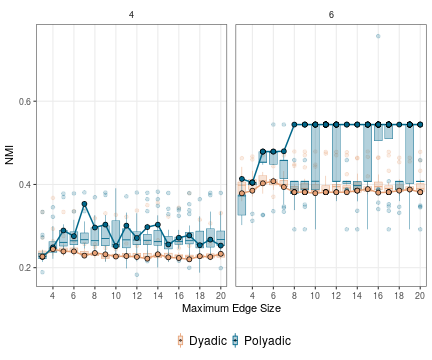

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [87]:
R"""

# levels <- c("2-Core (13,960 nodes)", "5-Core (335 nodes)", "10-Core (23 nodes)")


sub_df <- df %>% 
    arrange(desc(core)) %>% 
    group_by(method, kmax, core) %>% 
    filter(row_number() >= 0) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) 
  #  mutate(core = paste0(core, "-Core (", n_, " nodes)"),
  #         core = factor(core, levels = levels),
  #         method = factor(method)) %>% 

best_df <- sub_df %>% 
    group_by(method, kmax, core) %>% 
    filter(Q == max(Q))

sub_df %>% 
    ggplot() + 
    aes(x = factor(kmax), y = NMI) + 
    geom_boxplot(aes(color = method, fill = method), lwd = 0.2, outlier.alpha = .2, position = position_identity(), alpha = 0.3) + 
    geom_line(aes(color = method, group = method), data = best_df, lwd = .7) + 
    geom_point(aes(fill = method, x = factor(kmax), y = NMI), data = best_df, size = 2, pch = 21) + 
    facet_grid(~core) + 
    xlab("Maximum Edge Size") + 
    theme_bw() +
    theme(strip.background = element_blank(),
          panel.spacing = unit(3, "mm"),
          strip.text = element_text(size = 9),
          legend.position = "bottom",
          legend.text = element_text(size = 12),
          panel.grid.minor = element_blank(),
          legend.key.width = unit(0.4,"line")) + 
    scale_color_manual(name = "", 
                       values = c("#e6a176","#00678a"),
                       labels = c("Dyadic", "Polyadic")) + 
    scale_fill_manual(name = "", 
                      values = c("#e6a176","#00678a" ),
                      labels = c("Dyadic", "Polyadic")) + 
    scale_x_discrete(breaks = seq(4, 20, by = 2)) + 
    guides(fill = guide_legend(override.aes = list(size = 0.4)), 
           color = guide_legend(override.aes = list(size = 0.4)))
"""

In [49]:
R"""
ggsave("fig/walmart_boxplot.png", width = 5.5, height = 3)
"""

┌ Warning: RCall.jl: Warning: Duplicated override.aes is ignored.
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


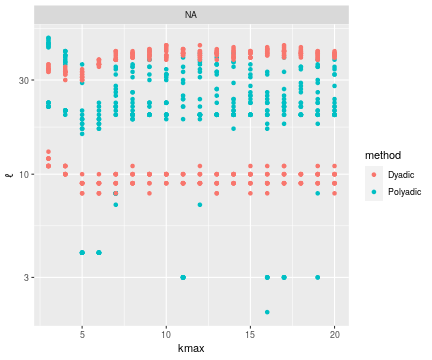

RObject{VecSxp}


In [50]:
R"""
df %>% 
    arrange(desc(core)) %>% 
    group_by(method, kmax, core) %>% 
    filter(row_number() >= 10) %>% 
    mutate(n_ = format(n,big.mark=",",scientific=FALSE)) %>% 
    mutate(core = paste0(core, "-Core (", n_, " nodes)"),
           core = factor(core, levels = levels),
           method = factor(method)) %>% 
    ggplot() + 
    aes(x = kmax, y = ℓ, color = method) + 
    geom_point() + 
    facet_wrap(~core) + 
    scale_y_continuous(trans = "log10")
"""